In [8]:
from IPython.display import display, HTML, clear_output, Markdown
import gc # for memory management
import pandas as pd
from openai import OpenAI
import os
import re
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

from helpers import (model_report, generate_top_k_table, generate_greedy_decoding_table, 
                     generate_detailed_beam_search, generate_top_k_sampling, generate_top_p_sampling,
                     plot_top_k_distribution, visualize_conversation
    )
                    
from introdl.utils import config_paths_keys, wrap_print_text

print = wrap_print_text(print, width = 100)
paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

MODELS_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models
DATA_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data
TORCH_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HUB_CACHE=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
Successfully logged in to Hugging Face Hub.


## What is a text-generation model?

Modern text-generation models are advanced AI systems designed to produce coherent and contextually relevant text based on a given input or prompt. They operate using an auto-regressive approach, where the model predicts the next word or token in a sequence based on the preceding ones. This iterative process continues until the desired length of text is generated, allowing the model to create fluid and natural-sounding language. These models are widely used in applications such as chatbots, content creation, and 
language translation.

In this notebook we:
1. give an optional brief chronological history to text generation
2. summarize a sample of recent models
3. examine the computational cost of text generation
4. discuss how text generation models are trained
5. introduce chat roles and how chatbots work
6. demonstrate the decoding strategies discussed in the textbook and discuss their use cases
7. show how to use local and api-based models with various decoding strategies
8. discuss how LLMs can be adapted for specialized use using fine-tuning and/or retrieval augmented generation (RAG)

There's a ton of material here, but much of it can be skimmed and treated as background.  I'll note which sections are important and will be included in the homework so you know where to focus your energy and time.  Your main focus should be on sections 5-8.  There's also a bit of homework related to section 3.

**Note:** Throughout this lesson we avoid using `llm_generate` from the course package.  Rather we show you how to use local and API-based models directly because these are both good things to know.


---

## **1. Chronology of Text Generation Approaches**

*This is a background section so just skim it.*

The evolution of text generation models reflects broader trends in natural language processing. Early models used statistical techniques, later enhanced by neural networks, recurrent architectures, and finally, transformers. The last few years have seen dramatic improvements with large-scale pre-training, instruction tuning, and the emergence of reasoning models and agents.

<details> 
<summary>If you're interested, you can CLICK HERE to see a detailed chronology.</summary>

---

### **Pre-2010s: Statistical Models and Rule-Based Systems**  
Early text generation systems relied on **statistical language models**, **n-grams**, and **rule-based methods**.

- **Markov Chains and N-grams:** These models generated text by predicting the next word based on the previous $n$ words, but they suffered from data sparsity and limited context.
- **Probabilistic Context-Free Grammars (PCFGs):** Used for structured text generation, especially in dialogue systems and machine translation.
- **2000s:** Phrase-based machine translation systems were common, particularly for tasks like translating short texts or building dialogue systems.

---

### **2010s: Neural Networks and Recurrent Architectures**  
The advent of deep learning dramatically improved text generation by learning complex patterns from large corpora.

- **2013–2014:** **Word Embeddings (Word2Vec, GloVe)** became standard for representing words in continuous vector space.
- **2014:** **Sequence-to-Sequence Models (Seq2Seq):** Introduced for machine translation and text generation using **LSTM (Long Short-Term Memory) networks**. Encoder-decoder architectures became foundational.
- **2015:** **Attention Mechanism:** Proposed by Bahdanau et al., allowing models to focus on specific parts of the input text, improving translation quality.
- **2015–2017:** **Variational Autoencoders (VAEs)** and **Generative Adversarial Networks (GANs)** explored for creative text generation but proved challenging to train.

---

### **Late 2010s: Transformers and Pre-trained Language Models**  
The introduction of transformers revolutionized text generation by enabling parallelized training and capturing long-range dependencies more effectively.

- **2017:** **Transformer Architecture (Vaswani et al.)** replaced recurrent networks with fully attention-based models, significantly improving machine translation and text generation.
- **2018:** **GPT (Generative Pre-trained Transformer):** OpenAI introduced a transformer-based, autoregressive language model pre-trained on a large corpus of text and fine-tuned for various tasks.
- **2019:** **GPT-2:** Scaled up the GPT architecture, achieving impressive text generation quality with zero-shot and few-shot capabilities.
- **2019:** **BERT:** Though primarily designed for understanding tasks, it influenced later models with its transformer-based architecture.

---

### **2020s: Large Language Models (LLMs), Instruction Tuning, Reasoning Models, and Agents**  
The 2020s have been dominated by progressively larger models trained with more sophisticated techniques to improve coherence, factuality, reasoning ability, and alignment with user intent.

---

#### **A. Large Language Models (LLMs)**
- **2020:** **GPT-3:** With 175 billion parameters, GPT-3 demonstrated strong few-shot learning capabilities. It became the basis for a wide range of text generation applications.
- **2021:** **T5 (Text-To-Text Transfer Transformer):** Unified NLP tasks by framing them all as text-to-text problems, paving the way for more versatile models.
- **2021–2022:** **Instruction Fine-Tuning:** Models are fine-tuned with human-labeled data to better follow instructions (e.g., InstructGPT).
- **2022:** **RLHF (Reinforcement Learning from Human Feedback):** Fine-tuning models using human preference data to improve alignment and quality.
- **2023:** **ChatGPT (GPT-4):** Demonstrated robust instruction-following abilities and multi-turn conversation handling, trained using both supervised fine-tuning and RLHF.
- **2023:** **LLaMA (Large Language Model Meta AI):** Released by Meta as a series of smaller, efficient models showing that high performance could be achieved with relatively fewer parameters.
- **2024–2025:** **LLaMA 3, Claude, Gemini:** Improved performance through better instruction-tuning, architecture modifications, and incorporating multimodal training data (text, images, code, etc.).

---

#### **B. Reasoning Models**  
The growing interest in making LLMs better at reasoning, planning, and performing multi-step tasks led to new architectures and training techniques.

- **2022:** **Chain-of-Thought (CoT) Prompting:** Improving reasoning by asking models to generate intermediate reasoning steps rather than answering directly.
- **2023:** **Self-Consistency Decoding:** Sampling multiple reasoning paths and selecting the most consistent one, improving robustness in reasoning tasks.
- **2024:** **Tree-of-Thoughts (ToT):** Extending Chain-of-Thought reasoning to generate, evaluate, and prune multiple reasoning paths in a structured manner.
- **2025:** **Multimodal Reasoning:** Incorporating images, code, and structured data into reasoning models for broader capabilities.

---

#### **C. Agents and Autonomy**  
Recent advances have enabled LLMs to act as **autonomous agents**, performing complex tasks by interacting with tools and environments.

- **2023:** **AutoGPT, BabyAGI:** Experimental frameworks designed to give LLMs autonomy in pursuing goals by generating sub-goals, retrieving information, and producing results over multiple steps.
- **2024:** **Toolformer (Meta):** A model that learns to use external tools (e.g., calculators, APIs) through fine-tuning, expanding the range of tasks it can handle.
- **2025:** **AgentBench:** Benchmarks developed to test LLMs acting as agents, including their ability to solve multi-step tasks with planning and reasoning.

---
</details>

### Chronology Summary Table

| Phase                | Key Techniques                               | Notable Models & Frameworks                            |
|----------------------|----------------------------------------------|-------------------------------------------------------|
| **Pre-2010s**        | N-grams, Markov Chains, Rule-based systems  | Phrase-based MT systems, PCFGs                        |
| **2010s (Early)**    | Word Embeddings, Seq2Seq with RNNs           | Word2Vec, GloVe, Seq2Seq, LSTM, GRU                  |
| **2010s (Late)**     | Attention, Transformers, Auto-regressive LM | GPT, GPT-2, BERT (for understanding)                 |
| **2020s (Early)**    | Large LMs, Zero-shot, Few-shot Learning      | GPT-3, T5, GPT-Neo                                    |
| **2020s (Mid-Late)** | Instruction Tuning, RLHF                    | InstructGPT, ChatGPT, LLaMA, Claude, Gemini          |
| **2020s (Late)**     | Reasoning Models, Autonomous Agents         | Chain-of-Thought, Tree-of-Thought, AutoGPT, Toolformer|

---


## **2. State-of-the-art Text Generation Models**

*The first part of this section will help you better understand how text-generation models (LLMs) work.  So at least watch the video.*

State-of-the-art text generation models, or LLMs, are auto-regressive, decoder-only architectures designed to predict the next token in a sequence based on prior context. These models leverage the transformer architecture, which uses self-attention mechanisms to capture long-range dependencies in text. 

Here's a picture I adapted from our textbook showing a typical decoder-only architecture:

<img src="pictures/Decoder_Example.png" alt="Decoder Example" width="1000">

Even with recent developments in resoning models, for now at least they still rely on the same transformer decoder architecture pictured here but use Chain-of-Thought prompting and generate multiple reasoning paths before selecting the most consistent result.

In the video below I discuss a few of the things in this picuture, including what "auto-regression" means, what those "token predictions" are, and how the final output token is determined.

#### L11_1_Text_Generation_Decoders Video

<iframe 
    src="nan" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="nan" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/lq84nRLeB3K" target="_blank">Open Descript version of video in new tab</a>

### A Snapshot of Current Models

*This section is background, though you'll need to use some of the numbers from the table below in the homework.*

I tend to geek out on LLMs so the following table very likely falls under the category of TMI ("Too Much Information"), but it's sample of some of the recent models in this space.  All of these models have been fine-tuned to follow instructions.  The DeepSeek-V3 model is the most advanced the table - it is designed to excel in reasoning tasks and it uses mixture-of-experts approach to dynamically select a subset of "expert" networks for each task.

<details>
<summary>CLICK HERE to see a table of some recent LLMs</summary>

| **Feature**                 | **LLaMA 3.3 70B Instruct** | **Llama 3.1 8B Instruct** | **DeepSeek-V3**          | **Qwen 2.5 (72B)**       | **GPT-4o Mini**         | **GPT-4o**               |
|-----------------------------|----------------------------|---------------------------|--------------------------|--------------------------|-------------------------|--------------------------|
| **Model Type**              | Open Source                | Open Source               | Open Source  | Open Source              | Proprietary             | Proprietary              |
| **Parameters**              | 70 billion                 | 8 billion                 | 671 billion (37B active) | 72.7 billion             | ?    | $\approx$ 200 billion            |
| **Transformer Layers**      | 80                         | 40                        | 61  | 80 | Not specified            | Not specified            |
| **Embedding Size**     | 16,384                     | 4,096                     | 7,168?                 | 8,192                    | unknown | 12,288 |
| **Vocabulary Size**         | 128,000 tokens             | 128,000 tokens            | 150,000 tokens           | 160,000 tokens           | 200,000 tokens          | 200,000 tokens           |
| **Context Window**          | 8,000 tokens               | 128,000 tokens            | 128,000 tokens           | 131,072 tokens           | 128,000 tokens          | 128,000 tokens           |
| **Maximum Output Tokens**   | 2,048 tokens               | 2,048 tokens              | 2,048 tokens             | 2,048 tokens             | 16,384 tokens           | 16,384 tokens            |
| **Reasoning Task Accuracy** | 44%                        | Not specified             | 55%                      | 60%                      | 69%                     | 80%+ (best performer)    |
| **Mathematical Tasks**      | Moderate                   | Not specified             | Strong                   | Strong                   | Moderate                | High (55%)               |
| **Coding Tasks (HumanEval)**| Strong performance         | Not specified             | Strong performance       | Very Strong              | Moderate                | High performance         |                  |
| **Cost (Input Tokens)**     | $0.23 per million tokens   | Not specified             | $0.20 per million tokens | $0.25 per million tokens | $0.15 per million tokens| $0.25 per million tokens |
| **Cost (Output Tokens)**    | $0.40 per million tokens   | Not specified             | $0.35 per million tokens | $0.40 per million tokens | $0.60 per million tokens| $10 per million tokens   |
| **Open Source Availability**| Yes (Customizable)         | Yes (Customizable)        | Yes (Customizable)       | Yes (Restricted)         | No                      | No                      |
| **Best For**                | Coding tasks, cost-effective | Multilingual dialogue, general-purpose | General-purpose, coding | Multilingual, mathematics, reasoning | Reasoning, multitasking | Broad tasks, high performance across all benchmarks |
| **Released By**             | Meta                       | Meta                      | DeepSeek                 | Alibaba                  | OpenAI                  | OpenAI                   |
| **Year Released**           | 2025                       | 2024                      | 2025                     | 2025                     | 2024                    | 2024                     |

</details>

---


## **3. Compute Cost for LLMs or Why is Text-Generatation so Slow?**

*There will be a related homework problem or two.  You don't have to understand all of the formulas here, but do get a general idea how they work and what quantities are involved as it will help you better understand transfomers.*

#### L11_1_Text_Generation_Cost Video

<iframe 
    src="nan" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="nan" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/89oyNf51xPP" target="_blank">Open Descript version of video in new tab</a>

By now you've probably noticed that text generation is much slower than using an already trained model for text-classification and NER tagging.  There are two main reasons for this:

1. LLMs are auto-regressive and require a forward model call for each new token.
2. Even small LLMs are much bigger models than task specific models like BERT.

To better understand the computational cost of transformers we can approximate the number of FLOPs or floating point operations used by a forward pass of transformer model.  This means we're counting the number of additions, subtractions, multiplications, and divisions.  The FLOPs count is dominated by the attention, feed-forward layers, and the final output layer. In particular we count the number of operations involved in each of the matrix multiplications. The other layers such as the normalization layers and activation functions are negligible. 

We won't derive the formulas here, but we'll give you some formulas for estimating the total FLOPs.  You can find details of these computations this article [How to Calculate the Number of FLOPS in Transformer Based Models](https://www.gaohongnan.com/playbook/training/how_to_calculate_flops_in_transformer_based_models.html#estimating-flops-for-a-single-forward-pass-of-gpt-2)

We'll use the following variables:
* $S$: length of the input sequence
* $D$: the embedding dimension (length of the embedding vectors and hidden states)
* $L$: number of transformer layers
* $N$: number of outputs (the number of logits from output layer after all the transformer layers)
* $T$: the number of embeddings passed through the final output layer (usually this is $S$ but not always)

We assume that the feed-forward network hidden layer has $4D$ neurons which is the typical size.

With that notation, the number of FLOPs from a single transformer layer is about
$$ 24 S D^2 + 4 S^2 D.$$

Notice the $S^2$ term.  This means that the cost is quadratic in the sequence length which is why extending transformers to handle very large input sequences (large context length) is difficult.

If we have $L$ transformer layers, then the FLOPs for processing a sequence through the transformer layers is 
$$L (24 S D^2 + 4 S^2 D).$$

This formula can be used for any architecture that uses transformer layers, whether an encoder or a decoder.

The final output layer can be significant, especially for text generation because the number of outputs is the vocabulary size and we pass all the embeddings through the output layer.  The number of FLOPs is 
$$2DTN.$$

In the case of text-generation model the whole sequence of embeddings is passed through the output layer so $T=S$ and the number of outputs is $V$, the vocabulary size so the number of FLOPs for the output layer is
$$2DSV.$$

To generate 1 token of new text thus requires
$$L (24 S D^2 + 4 S^2 D) + 2 D S V \text{ FLOPs}.$$

We truly don't expect you to understand how this formula is derived (but if you can that will advance your understanding of transformers).  Instead, we present the formula so you can see what the main contributions to the costs of using LLMs are.  Bigger models and longer sequences for context are great, but they come with increased costs.  A bigger model means more layers (larger $L$), increased embedding dimension (larger $D$), and perhaps a larger vocabulary ($V$).  Increasing context length means longer sequences ($S$).  

### Example: Generate 1 Token with LLama 3.1 8B

Let's suppose we have an input prompt with 200 tokens and we want to generate a single token of output.  For Llama 3.1 8B the relevant numbers are:

- **Parameters:** 8 billion
- **Transformer Layers (L):** 40
- **Embedding Dimension (D):** 4096
- **Vocabulary Size (V):** 128,000 tokens
- **Initial Prompt (S):** 200 tokens

We can use Python to do the math:

In [9]:
L = 40
D = 4096
S = 200
V = 128_000

def flops_one_token(L, D, S, V):
    return L*(24*S*D**2 + 4*S**2*D) + 2*D*S*V

FLOPs = flops_one_token(L, D, S, V)

print(f"FLOPs for generating 1 token: {FLOPs:,} or {FLOPs:.2e}")

FLOPs for generating 1 token: 3,457,155,072,000 or 3.46e+12


Wow!  That's about 3.5 trillion FLOPs to generate one token using the LLaMa 3.1 8B model.  While the formulas may not mean much wihout studying them, at least appreciate how large these numbers get.

Now if we want to generate 100 new tokens from based on an input prompt of length 200 tokens, then because the text generation is auto-regressive we need to first compute the FLOPs for an input sequence of length 200, then 201, then 202, all the way up to 299.

#### Example: Generate 100 New Tokens with LLaMa 3.1 8B

We'll use the same values as the previous example including the initial prompt with length 200.  Now we'll use a loop to add up the FLOPs for input sequences of length $200, 201, \ldots 299$

In [10]:
L = 40
D = 4096
V = 128_000

FLOPs_gen_100 = 0
for S in range(200,300):
    FLOPs_gen_100 += flops_one_token(L, D, S, V)
print(f"Total FLOPs for generating 100 tokens (S=200 to S=299): {FLOPs_gen_100:,} or {FLOPs_gen_100:.2e}")

Total FLOPs for generating 100 tokens (S=200 to S=299): 432,144,089,088,000 or 4.32e+14


That's 432 trillion FLOPs and 100 forward model passes which shows explains it takes a bit of time to generate text on our compute servers.

Let's compare that to the estimated number of FLOPs to do NER tagging for a 100 token sequence like we did last week for the CoNLL2023 data (BIO tagging: B-PER, I-PER, B-LOC, I-LOC, B-ORG, I-ORG, B-MISC, I-MISC, O).  

#### Example: Tagging a 100 Token Sequence using the BERT-base model

The BERT-base-cased model has about 110 million parameters, $L=12$ transformer layers, an embedding size of $D = 768$. For the final output layer we pass the whole sequence $S=100$ through the layer and map it to 9 possible tags which would be like using a vocabulary size $V=9$.  Let's plug that into our FLOPs estimator:

In [11]:
L = 12
D = 768
S = 100
V = 9

FLOPs_BERT = flops_one_token(L, D, S, V)
print(f"FLOPs for tagging a 100 token sequence with 9 possible tags using BERT-base: {FLOPs_BERT:,} or {FLOPs_BERT:.2e}")

FLOPs for tagging a 100 token sequence with 9 possible tags using BERT-base: 17,356,953,600 or
1.74e+10


How many times more FLOPs does it take to generate 100 new tokens of text than to tag a 100 token sequence?

In [12]:
print(f"FLOPs ratio for LLama-3.1-8B to BERT-base: {FLOPs_gen_100 / FLOPs_BERT:.2f}")

FLOPs ratio for LLama-3.1-8B to BERT-base: 24897.46


Not only do we need only 1 forward model pass for BERT-base to tag a sequence of 100 tokens compared to 100 serially executed model passes to generate 100 tokens of text.  The text generation model requires 25,000 times more FLOPs.  

**The Bottom Line:** While text-generating LLMs can be used as all purpose NLP tools, particularly when you don't have a lot of labeled data.  They're expensive to use and, as we've seen in the past few lessons, may not be as accurate as specialized transformer models for many NLP tasks.

## **4. Training a Text Generation Model (e.g., GPT, LLaMA, Gemini)**

*This section is background, but it's a good idea to have some idea of what goes into training the chatbots that most of use daily at this point.*

To get a better understanding of LLMs and text generation it helps to know how these models are trained.  In this section we'll break down the training process into **Pre-training**, **Instruction Fine-Tuning**, and **Learning Human Preferences**—all tailored to **Auto-Regressive Models**.

<details>
<summary>CLICK here for an outline of the training methods or at least look at the table below.</summary>

### **1. Pre-training (Self-Supervised Learning)**

**Objective:** Learn general language patterns, structure, grammar, facts, and broad knowledge from a large, diverse dataset.

####  **Process:**
- **Model Type:** Auto-Regressive Model (e.g., GPT, LLaMA, GPT-NeoX).
- **Dataset:** Huge corpus of **unlabeled text data** from diverse sources such as:
  - Books
  - Wikipedia
  - News articles
  - Forums, Websites, Code repositories
  - Social media posts (if applicable)
  
- **Training Objective:** **Next Token Prediction** (Auto-regressive Language Modeling)
  - Given a sequence of tokens $x_1, x_2, \ldots, x_{t-1}$, predict the next token $x_t$.
  - The model learns to maximize the probability:
    $$
    P(x_t | x_1, x_2, \ldots, x_{t-1})
    $$
  - This is done by minimizing the **Cross-Entropy Loss** over the entire dataset.
  
- **Optimization:** 
  - **AdamW** optimizer with **Gradient Clipping** and **Learning Rate Scheduling**.
  - Mixed-precision training (`fp16` or `bfloat16`) to reduce memory usage.
  
- **Hardware:** Multiple GPUs or TPUs due to the size of the model and dataset.

#### **Output:** 
A general-purpose language model that can generate coherent text based on general language understanding but is not specialized or aligned with specific tasks.


### **2. Fine-Tuning (Instruction Training with Labeled Data)**

**Objective:** Adapt the general-purpose model to **follow human instructions** and perform specific tasks more effectively.

#### **Process:**
- **Model Type:** Same architecture as pre-training (e.g., GPT-style).
- **Dataset:** **Labeled instruction-following data**, consisting of:
  - **Prompt-Response Pairs**: Text prompts paired with human-provided responses.
  - **Task Descriptions:** Instructions for tasks the model is expected to perform (e.g., summarization, translation, question answering, etc.).
  - **Open-ended Prompts:** Where the model generates text continuations based on creative or complex prompts.
  
- **Training Objective:** **Supervised Fine-Tuning**
  - The model is trained to generate appropriate responses to instructions.
  - This is typically done by minimizing the **Cross-Entropy Loss** over the labeled dataset.
  - The training objective remains the same:
    $$
    P(y_1, \ldots, y_n | x_1, \ldots, x_m)
    $$
    Where $x$ is the instruction and $y$ is the desired output.

- **Optimization:** 
  - Lower learning rates compared to pre-training.
  - Shorter training duration (often just a few epochs).
  
- **Hardware:** Fewer resources required than pre-training, but still typically done on GPUs.

#### **Output:** 
A model that is **better aligned with user prompts and can follow instructions effectively**. It can perform various tasks like:
- **Question Answering**
- **Summarization**
- **Translation**
- **Creative Writing**


### **3. Learning Human Preferences (Alignment with Human Feedback)**

**Objective:** Make the model produce helpful, accurate, and safe outputs that match what humans prefer.

#### **Process:** 
This step is called **Reinforcement Learning from Human Feedback (RLHF)**, but we can break it down into simpler parts:

#### **A. Collecting Human Feedback**
- **Collect examples** of good responses for different prompts.
- **Ask humans to rank outputs** from the model from best to worst (for example, when given the same prompt, which response is most helpful or safest?).

#### **B. Training a Scoring Model (Reward Model)**
- Build a separate model called a **Reward Model**.
- Train it to **score outputs based on human feedback** (higher score = better response).
- The model learns to predict what humans would rank as good responses.

#### **C. Improving the Original Model**
- Now, we use the scores from the **Reward Model** to help the original model improve.
- The original model is adjusted to produce outputs that get higher scores from the **Reward Model**.
- This helps the model generate responses that are more helpful, accurate, and aligned with human values.

### **Output:** 
A model that produces higher-quality and safer responses by learning from human feedback.

</details>

### **Summary Table**

| Phase          | Objective                         | Data Type                         | Training Method                           | Output                                    |
|----------------|-----------------------------------|----------------------------------|-----------------------------------------|-----------------------------------------|
| **Pre-training**      | General language understanding   | Unlabeled text corpus            | Auto-regressive Language Modeling       | General-purpose LLM |
| **Instruction Fine-Tuning** | Instruction following         | Labeled instruction-response pairs | Supervised Fine-Tuning                  | Task-specific model, better at following instructions |
| **RLHF (Alignment)** | Align with human preferences    | Human preference pairs           | Reinforcement Learning (PPO)            | Model that aligns well with human intentions and preferences |


In practice your company or organization is unlikely to train an LLM from scratch.  They'll use an already trained model and adapt it for their purposes.  What that looks like will depend on the use-case and data-security concerns.  We'll discuss a couple of ways that LLMs are adapted at the end of this notebook.  

In the next section we'll concentrate on the final decoding step where the output of model is used to pick the next token in the sequence.


---

## **5. Chatbots and Chat Roles**

*This section is important.  Both to see how local models and API-based models generate text and also to understand chat roles and chatbots.*

#### L11_1_Chat_Roles Video

<iframe 
    src="nan" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="nan" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/GDRk92GqkN4" target="_blank">Open Descript version of video in new tab</a>


Modern **Large Language Models (LLMs)**, especially those designed for conversational tasks, are often **trained with structured roles** to produce coherent, task-oriented responses.  

### Training with Roles

- Models like **GPT-4o**, **Claude**, **Gemini**, and **LLaMA** are often trained or fine-tuned using datasets that include **explicit roles** such as:
  - **`system`** - Instructions or context setting.
  - **`user`** - Queries or inputs from the human user.
  - **`assistant`** - Model-generated responses.
- Training with roles helps models:
  - **Follow instructions accurately.**
  - **Maintain context over extended interactions.**
  - **Generate appropriate, role-specific outputs.**

### API Compatibility

- **OpenAI, Groq, and other providers** now use standardized API structures that explicitly define roles, enhancing **alignment, coherence, and safety**.

#### Common Chat Roles

| **Role**      | **Purpose**                                      |
|---------------|--------------------------------------------------|
| `system`      | Provides initial instructions or sets context.   |
| `user`        | Represents the human’s input or query.           |
| `assistant`   | Represents the model’s response.                 |

#### Why Are Roles Important?

- **Guidance:** Establishes the model’s purpose or behavior (e.g., “You are a helpful assistant.”).  
- **Structure:** Organizes interactions for better coherence.  
- **State Management:** Facilitates continuous dialogue with memory of prior exchanges.  


### Using Chat Roles with a Local Model

We'll demonstrate how to use chat roles with local Hugging Face models.  Most recent LLM models on HuggingFace include a chat_template as an attribute of the tokenizer.  The chat_template takes a conversation that includes chat roles (we'll seen an example below) and formats as text in the format expected by the LLM model before tokenizing it.  In the example below we also decode the formatted conversation and print it for illustration, but you wouldn't normally do this before sending the tokenized conversattion to the model.

We've selected Llama-3.1-8B-instruct, but you could do this with almost any local model.

In [13]:
# Load the model and tokenizer
model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

# Define conversation with chat roles
conversation = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Explain how transformers work in NLP."}
]

# Apply the chat template if available
if hasattr(tokenizer, "apply_chat_template") and getattr(tokenizer, "chat_template", None) is not None:
    input_ids = tokenizer.apply_chat_template(
        conversation,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)
    
    # Decode the formatted input to see how the conversation has been structured
    formatted_input = tokenizer.decode(input_ids[0], skip_special_tokens=False)
    print("Formatted Conversation (After Applying `chat_template`):\n")
    print(formatted_input)
    print('----------------------------------------------------------------------------\n')
else:
    raise ValueError("The tokenizer does not support chat_template.")

# Generate a response using the model
output = model.generate(input_ids, max_length=100)
print("\nModel Output:\n", tokenizer.decode(output[0], skip_special_tokens=True))


Formatted Conversation (After Applying `chat_template`):

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

Explain how transformers work in NLP.<|eot_id|>
----------------------------------------------------------------------------


Model Output:
 system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful assistant.user

Explain how transformers work in NLP.assistant

Transformers are a type of neural network architecture that has revolutionized the field of Natural
Language Processing (NLP). They were first introduced in the paper "Attention Is All You Need" by
Vaswani et al. in 2017.

**


You can see that the local model always returns the prompt as part of its output when you use the chat_template.  If you're trying to get structured output you'll often need to do some processing to remove the prompt.  In a chatbot application the output of the model is appended to the conversation using the assitant role before the next user prompt and the entire conversation if fed back to the model to generate a response.  This is how chatbots are able to use the entire context of the conversation to generate coherent responsese.  We'll demonstrate how a chatbot works further below.

To remove the unwanted text it can be helpful to instruct the LLM to print something like `<BOS>` at the beginning of its response.  Then we can use regular expressions to search for that and delete everything up to that spot.  The code below demonstrate this.  

We'll also show you how to clear a model from memory and load a different local model.  If you load a local model repeatedly or load too many different local models you'll run out of GPU memory. It's not necessary to reload the model each time you use it either.

This first cell clears the previous model:

In [14]:
# Delete the model
del model  
del tokenizer

# Clear CUDA cache
torch.cuda.empty_cache()

# Run garbage collection
gc.collect()

5620

This cell loads the new model and tokenizer:

In [15]:
# Load the model and tokenizer
model_name  = "unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

Finally, this cell sets up the conversation, generates the output, and displays both the raw and cleaned output.  

In [16]:
# Define conversation with chat roles, instructing the LLM to prepend <BOS> to its output
conversation = [
    {"role": "system", "content": "You are a helpful assistant. Always begin your response with the special token '<BOS>'."},
    {"role": "user", "content": "Explain how transformers work in NLP."}
]

# Apply the chat template if available
if hasattr(tokenizer, "apply_chat_template") and getattr(tokenizer, "chat_template", None) is not None:
    input_ids = tokenizer.apply_chat_template(
        conversation,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(model.device)
    
    # Decode the formatted input to see how the conversation has been structured
    formatted_input = tokenizer.decode(input_ids[0], skip_special_tokens=False)
    print("Formatted Conversation (After Applying `chat_template`):\n")
    print(formatted_input)
    print('----------------------------------------------------------------------------\n')
else:
    raise ValueError("The tokenizer does not support chat_template.")

# Generate a response using the model
output = model.generate(input_ids, max_length=200)
response = tokenizer.decode(output[0], skip_special_tokens=True)

print("\nModel Output (Raw):\n", response)
print('----------------------------------------------------------------------------\n')

# Remove everything up to and including <BOS> and any whitespace following it
# Use regex to match the <BOS> tag and strip any newlines or spaces after it
cleaned_response = re.sub(r".*<BOS>\s*", "", response, flags=re.DOTALL).lstrip()

# Print the cleaned output
print("\nModel Output (Cleaned):\n", cleaned_response)


Formatted Conversation (After Applying `chat_template`):

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 04 Apr 2025

You are a helpful assistant. Always begin your response with the special token
'<BOS>'.<|eot_id|><|start_header_id|>user<|end_header_id|>

Explain how transformers work in NLP.<|eot_id|>
----------------------------------------------------------------------------


Model Output (Raw):
 system

Cutting Knowledge Date: December 2023
Today Date: 04 Apr 2025

You are a helpful assistant. Always begin your response with the special token '<BOS>'.user

Explain how transformers work in NLP.assistant

<BOS>

Transformers are a type of neural network architecture that revolutionized the field of Natural
Language Processing (NLP) in 2017. They were introduced in the paper "Attention is All You Need" by
Vaswani et al. The core idea behind transformers is to replace traditional recurrent neural networks
(RNNs) and conv

You could now generate more text in subsequent calls without reloading the model.  You'd only need to clear it if you wanted to load a different model.


### Using Chat Roles with an API

To use chat roles with an API-based LLM you format the conversation in the same way.  The difference is that the chat_template is applied on the server so that you don't have to manage it.  API-based LLMs also usually remove the input prompt from the output.  Here we demonstrate with a Gemini model.  You'll need your GEMINI_API_KEY to run this code.


In [17]:
# Initialize the Gemini API client
client = OpenAI(
    api_key=os.getenv("GEMINI_API_KEY"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Define conversation with chat roles
conversation = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Explain how transformers work in NLP."}
]

# Make the API request
try:
    response = client.chat.completions.create(
        model="gemini-2.0-flash-lite",
        messages=conversation,
        max_tokens=200,  # Limit the response length to 200 tokens
    )
    print(response.choices[0].message.content)
except Exception as e:
    print(f"Error: {e}")


Let's break down how transformers work in Natural Language Processing (NLP).  They've revolutionized
the field and power things like Google Translate, chatbots, and text summarization.  Here's a
simplified explanation, going from the core concepts to the overall architecture:

**1. Core Concept:  Attention**

The heart of a transformer is the "attention mechanism". This is what sets it apart from previous
architectures like Recurrent Neural Networks (RNNs). Instead of processing words sequentially,
attention allows the model to:

*   **Focus on Relevant Parts:** When processing a word, the attention mechanism helps the model
understand which other words in the sentence are most important for understanding the meaning of
that word. Think about it:  when you read "The cat sat on the mat," you intuitively understand that
"sat" is related to "cat" and "mat". Attention captures these relationships.
*   **Process in Parallel:**  Unlike RNNs, which process words one at


Note, it's a pretty simple matter to render that markdown for display in a notebook environment as we show with the next cell:

In [18]:
display(Markdown(response.choices[0].message.content))

Let's break down how transformers work in Natural Language Processing (NLP).  They've revolutionized the field and power things like Google Translate, chatbots, and text summarization.  Here's a simplified explanation, going from the core concepts to the overall architecture:

**1. Core Concept:  Attention**

The heart of a transformer is the "attention mechanism". This is what sets it apart from previous architectures like Recurrent Neural Networks (RNNs). Instead of processing words sequentially, attention allows the model to:

*   **Focus on Relevant Parts:** When processing a word, the attention mechanism helps the model understand which other words in the sentence are most important for understanding the meaning of that word. Think about it:  when you read "The cat sat on the mat," you intuitively understand that "sat" is related to "cat" and "mat". Attention captures these relationships.
*   **Process in Parallel:**  Unlike RNNs, which process words one at

### Chatbot Simulation

#### L11_1_Chatbots Video

<iframe 
    src="nan" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="nan" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/mVH5RLMCj7N" target="_blank">Open Descript version of video in new tab</a>

Chatbots work by appending the LLM output to the conversation using the "assistant" role before adding the next user prompt.  The whole conversation, as long as it fits inside the context length of the LLM, is processed by the model to generate the next resonse.  Here's a demonstration:

In [19]:
# Initialize the Gemini API client
client = OpenAI(
    api_key=os.getenv("GEMINI_API_KEY"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Initialize the conversation with a system prompt
conversation = [
    {"role": "system", "content": "You are a helpful assistant. Answer questions concisely and clearly."}
]

def chat_with_gemini(user_input, model="gemini-2.0-flash-lite"):
    """
    Add user input to the conversation, generate a response, and visualize the conversation.
    """
    conversation.append({"role": "user", "content": user_input})

    try:
        # Make the API request
        response = client.chat.completions.create(
            model=model,
            messages=conversation
        )

        # Extract the assistant's response
        assistant_response = response.choices[0].message.content

        # Add the assistant's response to the conversation
        conversation.append({"role": "assistant", "content": assistant_response})

        # Visualize the updated conversation
        visualize_conversation(conversation) # from helpers.py - formats conersation nicely for display

    except Exception as e:
        print(f"Error: {e}")


In [20]:
chat_with_gemini("What are tranformers in NLP?")

# Conversation Flow
### **System:** You are a helpful assistant. Answer questions concisely and clearly.

**User:** What are tranformers in NLP?

**Assistant:** Transformers are a type of neural network architecture that has become a dominant force in Natural Language Processing (NLP). Unlike recurrent networks, transformers process the entire input sequence simultaneously, enabling parallelization and capturing long-range dependencies more effectively. They rely on self-attention mechanisms to weigh the importance of different words in a sentence, allowing the model to understand context and relationships.




In [21]:
chat_with_gemini("How do their attention mechanisms work?")

# Conversation Flow
### **System:** You are a helpful assistant. Answer questions concisely and clearly.

**User:** What are tranformers in NLP?

**Assistant:** Transformers are a type of neural network architecture that has become a dominant force in Natural Language Processing (NLP). Unlike recurrent networks, transformers process the entire input sequence simultaneously, enabling parallelization and capturing long-range dependencies more effectively. They rely on self-attention mechanisms to weigh the importance of different words in a sentence, allowing the model to understand context and relationships.


**User:** How do their attention mechanisms work?

**Assistant:** Attention mechanisms in transformers work by calculating "attention weights" for each word in a sequence. These weights determine how much each word contributes to the representation of other words. Essentially, the model learns to focus on the most relevant parts of the input when processing each word, enabling it to understand context and relationships within the text.




In [22]:
chat_with_gemini("Can you explain how they are trained?")

# Conversation Flow
### **System:** You are a helpful assistant. Answer questions concisely and clearly.

**User:** What are tranformers in NLP?

**Assistant:** Transformers are a type of neural network architecture that has become a dominant force in Natural Language Processing (NLP). Unlike recurrent networks, transformers process the entire input sequence simultaneously, enabling parallelization and capturing long-range dependencies more effectively. They rely on self-attention mechanisms to weigh the importance of different words in a sentence, allowing the model to understand context and relationships.


**User:** How do their attention mechanisms work?

**Assistant:** Attention mechanisms in transformers work by calculating "attention weights" for each word in a sequence. These weights determine how much each word contributes to the representation of other words. Essentially, the model learns to focus on the most relevant parts of the input when processing each word, enabling it to understand context and relationships within the text.


**User:** Can you explain how they are trained?

**Assistant:** Transformers are trained using a process called **backpropagation**, similar to other neural networks.

1.  **Data Preparation:** Text data is converted into numerical representations (tokens) and prepared in batches.
2.  **Forward Pass:** The input is fed through the transformer, which calculates attention weights and generates output representations.
3.  **Loss Calculation:** The model's output is compared to the expected output (e.g., the next word in a sequence), and a loss function (e.g., cross-entropy) quantifies the error.
4.  **Backward Pass (Backpropagation):** The error is propagated back through the network to calculate gradients (how much each weight contributed to the error).
5.  **Weight Updates:** The model's weights are adjusted using an optimization algorithm (e.g., Adam) to minimize the loss.
6.  **Iteration:** Steps 2-5 are repeated iteratively over the training data until the model converges (learns to perform well on the training data).

Popular training methods include:

*   **Masked Language Modeling (MLM):** The model predicts masked words in a sentence.
*   **Next Sentence Prediction (NSP):** The model predicts if two sentences are consecutive.





---

## **6. Decoding Strategies - Converting Probabilities to Tokens**

*This section is important.  Decoding methods shape the output of an LLM.  The methods in this section will be in the homework.*

#### L11_1_Decoding_Strategies Video

<iframe 
    src="nan" 
    width="800" 
    height="450" 
    style="border: 5px solid cyan;"  
    allowfullscreen>
</iframe>
<br>
<a href="nan" target="_blank">Open UWEX version of video in new tab</a>
<br>
<a href="https://share.descript.com/view/LQx3wLJEV1F" target="_blank">Open Descript version of video in new tab</a>

Decoding strategies are the main focus of the textbook so I'm not going to go into great detail on each of them, but I had a bit of trouble following the book in places and perhaps you did too.  I'm going to go through a series of demonstrations to try to help you get a bit of insight into the decoding strategies.  All of these strategies: greedy search, beam search, top_k search, and top_p search are available with local models and all but beam search are available in most API-based models.  Many commercial providers serve the same models that we can run locally, but don't expose or provide access to the beam search option for those models.

Throughout this section will make use of various functions we created in `helpers.py` that are imported near the top of this notebook.

**Note:**  We're not making use of chat_templates in this section to keep things simple.  But you can use chat_templates and assign roles with the different decoding strategies.  Using chat_templates will cause local models to output the whole conversation so you'll need to post-process to remove the output you don't want.


### Output of the Model

Let's review what the output of our decoder model is.  Given the current input sequence, the classification head maps the final hidden states of the transformer layers to logits, one for each possible token in the vocabulary.  Those logits are then passed through a softmax to get a probability distribution for the next possible token.  To demonstrate we'll load the quantized Llama-3.2-3B instruction fine-tuned model that we've used previously with `llm_generate`.  **You must have a GPU for this to work (use a compute server).**

In [23]:
# Instantiate model and tokenizer (uncomment if you need to reload the model)
# model_name  = "unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit"
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

model_report(model, tokenizer)


Model Report for llama
---------------------------
Vocabulary Size: 128256
Embedding Dimension: 3072
Number of Transformer Blocks: 28
Total Number of Parameters: 1,841,212,416


Now let's see what the next token probility distribution looks like if we start with the input sequences "Transformers are the" and ask for the next token.  The `top_k` highest probability tokens will be displayed.

In [24]:
df = generate_top_k_table(model, tokenizer, "Transformers are the", top_k=20, temperature = 1.0)
print("Top K Table")
display(HTML(df.to_html(index=False)))

Top K Table


Word,Probability (%)
ultimate,12.695312
most,6.378174
perfect,2.967834
latest,2.293396
iconic,2.239990
best,1.976013
embodiment,1.276398
result,1.198578
main,1.083374
machines,1.009369


This probability distribution gives a conditional probability (conditioned on the previous sequence) for every possible token in the vocabulary.  The character of the text we generate from these probabilities is determined by how we use these probabilities to select the next token.  We can also visualize this probability distribution:

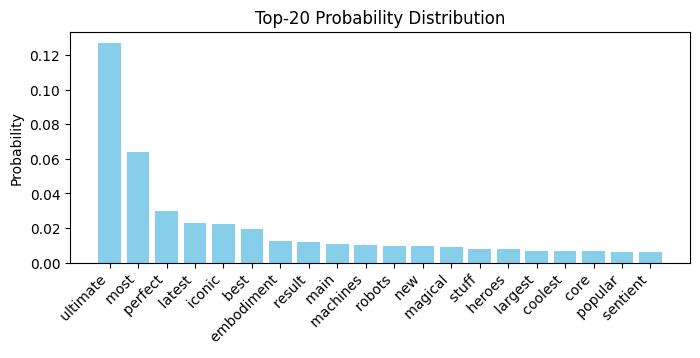

In [25]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='pdf', temperature=1.0,figsize=(8,3))

 and its cumulative distribution:

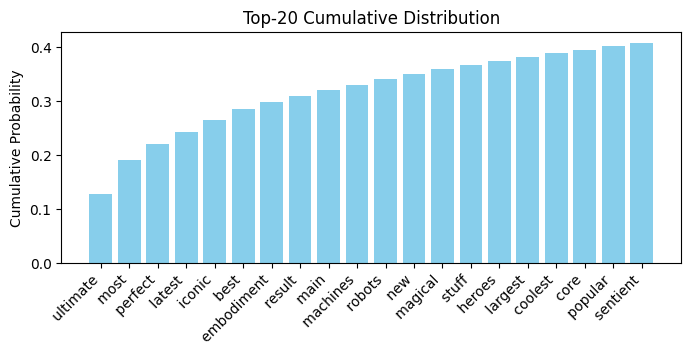

In [26]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='cdf', temperature=1.0, figsize=(8,3))

This is a great place to explore the role of the temperature parameter $T$ in this probability distribution.  The temperature is used to increase ($T>1$) or decrease ($0<T<1$) the randomness of the top_p and top_k sampling methods.  It doesn't have any effect on deterministic search methods like greedy decoding and beam search.

A small value of $T$ leads to a "sharper" probability distribution that places more emphasis on the early tokens so that top ranked words are much more likely to be selected. For example, many LLM's default to a value around $0.7$:

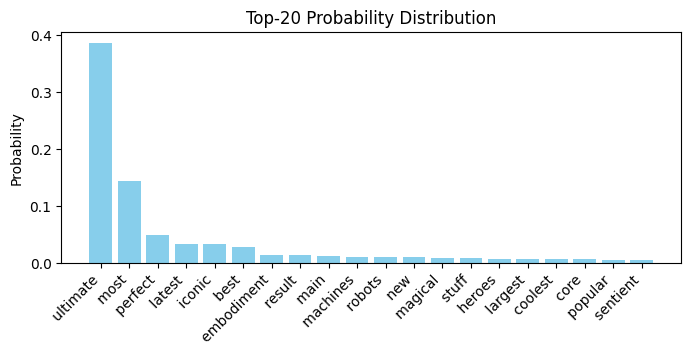

In [27]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='pdf', temperature=0.7,figsize=(8,3))

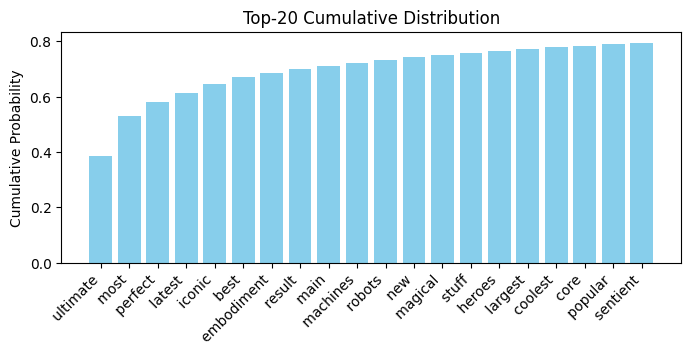

In [28]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='cdf', temperature=0.7,figsize=(8,3))

Conversely, a large value of temperature flattens the probability distribution making it closer to uniform.  This makes lower ranked words much more likely.  For example $T=1.3$ gives:

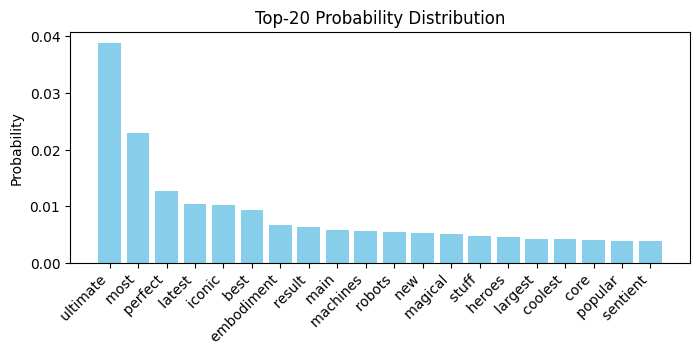

In [29]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='pdf', temperature=1.3,figsize=(8,3))

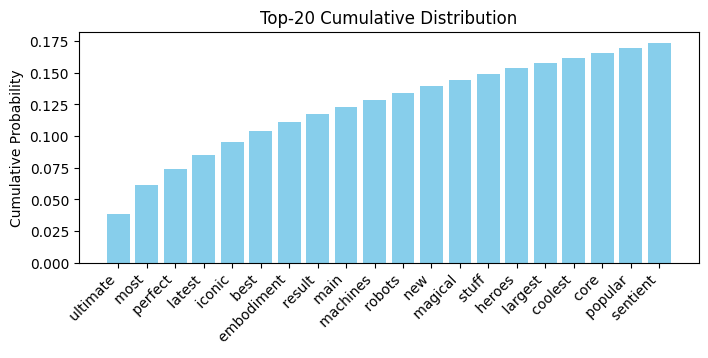

In [30]:
prompt = "Transformers are the"
plot_top_k_distribution(model, tokenizer, prompt, top_k=20, plot_type='cdf', temperature=1.3,figsize=(8,3))

Now let's review the four main decoding strategies.  Each strategy stops when the maximum number of new tokens is reached or when a special "end of sequence" token is selected.

### The Greedy Decoding Strategy

This approach is called "greedy" because it greedily chooses the next token to be the token with the largest probability.  It's the fastest of the decoding methods.  This deterministic approach is good for tasks where consistency and coherency are more important than creativity like code-generation or factual question answering.

To better understand how it works lets show a sequence is generated by printing a table of the top 5 completions and appending the one with the largest probability at each iteration.   

In [31]:

# Example usage
prompt = "Transformers are the"
df = generate_greedy_decoding_table(model, tokenizer, prompt, max_length=10)
# Display with styling to limit width and wrap text
display(HTML(df.to_html(escape=False, notebook=True, max_rows=None)))

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,ultimate (12.70%),most (6.38%),perfect (2.97%),latest (2.29%),iconic (2.24%)
1,Transformers are the ultimate,symbol (17.36%),shape (6.90%),symbols (4.25%),in (2.31%),action (2.26%)
2,Transformers are the ultimate symbol,of (99.61%),for (0.07%),in (0.05%),\n (0.02%),and (0.02%)
3,Transformers are the ultimate symbol of,childhood (12.92%),the (8.34%),power (5.64%),(2.86%),nostalgia (2.44%)
4,Transformers are the ultimate symbol of childhood,wonder (21.14%),nostalgia (20.18%),imagination (14.31%),excitement (8.22%),play (3.70%)
5,Transformers are the ultimate symbol of childhood wonder,and (70.12%),", (16.39%)",. (10.10%),! (0.87%),– (0.45%)
6,Transformers are the ultimate symbol of childhood wonder and,excitement (42.04%),imagination (19.86%),play (6.10%),nostalgia (4.40%),magic (4.20%)
7,Transformers are the ultimate symbol of childhood wonder and excitement,. (70.02%),", (14.69%)",! (8.23%),for (2.85%),in (1.99%)
8,Transformers are the ultimate symbol of childhood wonder and excitement.,Who (32.40%),These (16.28%),They (7.57%),From (6.79%),Whether (5.63%)
9,Transformers are the ultimate symbol of childhood wonder and excitement. Who,wouldn (42.07%),can (26.73%),doesn (12.24%),among (4.64%),needs (3.51%)


### Beam Search

Beam search is a decoding algorithm used to generate sequences in language models by maintaining a fixed number of the most probable sequences, called beams, at each step. Unlike greedy search, which selects only the highest-probability token at each step, beam search explores multiple possibilities and keeps the top num_beams sequences based on their cumulative probabilities. As the model generates tokens, beam search extends each beam by all possible next tokens and keeps only the top num_beams sequences. This approach helps balance quality and diversity of output compared to simpler methods like greedy search.  It's commonly used for machine translation, summarization, and other tasks requiring coherence.

I like the following description of beam search from [Inference Speed Is the Key To Unleashing AI's Potential](https://groq.com/wp-content/uploads/2024/05/2024_GroqThoughts_Inference-Speed-Is-the-Key-To-Unleashing-AIs-Potential.pdf) from the LLM API provider Groq:


"Beam search, for example, is a kind of 'search ahead'
technique that generates better results by looking ahead
at a possible set of outcomes, then selecting the best one
based on a scoring function. Think of a chess-playing bot
who, rather than just predicting its next move, gives itself
ten different next-move options and plays out the match
for each of those ten. It may discover that what it thought
was its best next move was in fact inferior to another
option. If it simply relies on its stream of consciousness, its
quality won’t be as good as it could be."

The following demo requires you to press "Enter" to seach each step of the beam search.  At each step we accumulate the sum of the log probabilities and select the top `num_beams` sequences.  Here we demonstrate beam search with just two beams and considering 3 possible completions of each beam at each iteration:

In [32]:
prompt = "Transformers are the"
df = generate_detailed_beam_search(model, tokenizer, prompt, num_beams=2, max_length=6, temperature=1.0);
display(df)



=== Step 6: Top 3 Completions for Each Beam ===


,Beam,Completion 1,Completion 2,Completion 3
0,Transformers are the ultimate symbol of childhood wonder,and (0.7012),", (0.1639)",. (0.1010)
1,Transformers are the ultimate symbol of childhood nostalgia,", (0.3750)",for (0.2346),. (0.2136)



=== Step 6: Expanded Beams (Unsorted) ===


,Beam,Text,Previous Log Prob Sum,Log Prob of New Word,New Log Prob Sum
0,1,Transformers are the ultimate symbol of childhood wonder and,-7.419930,-0.354980,-7.774910
1,2,"Transformers are the ultimate symbol of childhood wonder,",-7.419930,-1.808594,-9.228523
2,3,Transformers are the ultimate symbol of childhood wonder.,-7.419930,-2.292969,-9.712898
3,4,"Transformers are the ultimate symbol of childhood nostalgia,",-7.466805,-0.980957,-8.447762
4,5,Transformers are the ultimate symbol of childhood nostalgia for,-7.466805,-1.450195,-8.917000
5,6,Transformers are the ultimate symbol of childhood nostalgia.,-7.466805,-1.543945,-9.010750


None

Both beam search and greedy decoding are deterministic.  Now we'll consider top_k and top_p sampling which both generate random responses, but differ in how the probability distribution is used to select the next token.

### Top-k sampling

In top-k sampling, we randomly choose from the k tokens with the highest probabilities.  These probabilities are renormalized so that they sum to 1 at each step.  We then sample from the top-k tokens according to the renormalized probilities. Top-k sampling limits the possible randomness by using only the top-k tokens. It is useful for creative tasks where you want some diversity but not complete randomness.

The demo below below gives you an idea how this works.  You must press enter at each iteration to see the next sequence.  Try running it a few times to see how the results vary.  If you decrease the temperature (try 0.7 or 0.5) that should decrease the variability.  Similarly, increasing the temperature will increase the variation of the output sequences.

In [33]:
prompt = "Transformers are the"
df = generate_top_k_sampling(model, tokenizer, prompt, max_length=6, top_k = 5, temperature=1.0);
display(df)



=== Step 6 ===
Current Sequence: Transformers are the ultimate in robotic transformation,


,Step,Completion 1,Completion 2,Completion 3,Completion 4,Completion 5
0,Original Probabilities,allowing (0.3284),but (0.1208),where (0.1050),with (0.0780),and (0.0593)
1,Renormalized Probabilities,allowing (0.4749),but (0.1747),where (0.1519),with (0.1128),and (0.0858)
2,Selected Completion,allowing,but,where,with,and


None

### Top-p Sampling (also called Nucleus Sampling)

In top-p sampling, we randomly choose from all the highest ranked tokens whose cumulative probability is approximately $p$.  For example if we're doing top-90% sampling, we first find the tokens that make up the top 90% of all possible tokens.  How many tokens this is varies at each step as the overall distribtion changes.  The probabilities corresponding to the top-p tokens are renormalized and then we randomly sample from those tokens according to the renormalized probabilities.  The set of tokens to be sampled is dynamic.  This method is more flexible than top-k and is often used where creativeness is important.

The demo below below gives you an idea how this works.  You must press enter at each iteration to see the next sequence.  Try running it a few times to see how the results vary.  If you decrease the temperature (try 0.7 or 0.5) that should decrease the variability.  Similarly, increasing the temperature will increase the variation of the output sequences.

Settings of `top_p = 0.9` and `temperature = 0.7` are very common in chatbot applications so we'll demonstrate with those here:

In [34]:
prompt = "Transformers are the"
generate_top_p_sampling(model, tokenizer, prompt, max_length=8, top_p=0.9, temperature=0.7)


=== Step 8 ===
Current Sequence: Transformers are the most popular toys of all time,


,Step,Completion 1,Completion 2,Completion 3,Completion 4,Completion 5,Completion 6,Completion 7,Completion 8
0,Original Probabilities,and (0.7065),with (0.2258),,,,,,
1,Renormalized Probabilities,and (0.7578),with (0.2422),,,,,,
2,Selected Completion,and,with,,,,,,


### Summary of the Decoding Methods

Here's a summary table comparing **various LLM decoding strategies**, their **typical use cases**, and **strengths and weaknesses**.


Got it! I've updated the table to **exclude `early_stopping`**, and we’ll address it separately when demonstrating the strategies with HuggingFace models in the next section.



| **Decoding Strategy** | **Typical Use Cases**                          | **Typical Parameters**                        | **Strengths**                           | **Weaknesses**                         |
|-----------------------|------------------------------------------------|---------------------------------------------|----------------------------------------|---------------------------------------|
| **Greedy Search**     | - Closed-form tasks (e.g., QA, summarization)  <br> - Code generation with deterministic results | `max_length=256`  | - Fast and efficient <br> - Produces consistent, coherent output | - Prone to repetition <br> - Lacks diversity and creativity |
| **Beam Search**       | - Machine translation <br> - Summarization <br> - Text completion where coherence is critical | `num_beams=4` <br> `max_length=256` | - High coherence <br> - Balances quality vs. diversity <br> - Returns multiple candidates | - Computationally expensive <br> - May produce bland or repetitive outputs |
| **Top-k Sampling**    | - Creative writing <br> - Dialog systems <br> - Story generation <br> - Poetry | `top_k=50` <br> `temperature=0.8` <br> `max_length=256` | - Encourages diversity <br> - Limits randomness by sampling from top-k tokens | - May still produce low-quality outputs <br> - Quality highly dependent on \( k \) |
| **Top-p Sampling (Nucleus Sampling)** | - Conversational AI <br> - Creative writing <br> - Dialogue generation | `top_p=0.9` <br> `temperature=0.7` <br> `max_length=256` | - High diversity <br> - More flexible than Top-k by adjusting cumulative probability | - May generate irrelevant or incoherent text if \( p \) is too high |
| **Temperature Scaling** (Usually combined with other strategies) | - Adjusting randomness across tasks <br> - Balancing creativity and coherence | `temperature=0.7` (for creative tasks) <br> `temperature=0.1` (for factual tasks) | - Can fine-tune creativity by adjusting temperature | - Poor choice of temperature can degrade performance (e.g., too low = deterministic, too high = chaotic) |




## **7. Decoding Strategies with Local and API-based Models**

*You should go through this section.  You'll have related homework questions.*

In this section we'll demonstrate how to implement the various decoding methods with local models.  Watch the video below to get an explanation of the code in the next cell.

**Note:** We're not using chat roles or chat_template here to keep things simple, but you can.  You'd likely want to clean the output to display only the new output.  We demonstrated this in Section 5 above.

In [35]:
# Load the model and tokenizer (UNCOMMENT if don't already have them loaded)
# model_name  = "unsloth/Llama-3.2-3B-Instruct-unsloth-bnb-4bit"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')

# Initial prompt
prompt = 'Transformers are the'
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(model.device)

print('Model and tokenizer loaded successfully.')

# Function to generate text
def generate_text(input_ids,**kwargs):
    output = model.generate(input_ids, **kwargs)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(generated_text)

# Greedy Search
print('\nDemonstrating Greedy Search...\n')
generate_text(
    input_ids,
    max_length=50,
    do_sample=False,  # Ensures deterministic output
    temperature=None,  # Greedy search does not use temperature, set to None to avoid warning
    top_p = None,  # Greedy search does not use top-p, set to None to avoid warning
)
# equal to model.generate(input_ids, max_length=50, do_sample=False, temperature=None, top_p=None)


# Beam Search
print('\nDemonstrating Beam Search...\n')
generate_text(
    input_ids, 
    max_length=50, 
    do_sample=False, # Ensures deterministic output
    num_beams=4,  # Number of beams for beam search
    early_stopping=True,  # Stops generation when the model predicts an end token
    temperature=None,  # Beam search does not use temperature, set to None to avoid warning
    top_p = None  # Beam search does not use top-p, set to None to avoid warning
)

# Top-k Sampling
print('\nDemonstrating Top-k Sampling...\n')
generate_text(
    input_ids,
    max_length=50,
    do_sample=True,   # Enables sampling
    top_k=50,         # Limits sampling to the top 50 tokens by probability
    temperature=0.8
)

# Top-p Sampling
print('\nDemonstrating Top-p Sampling...\n')
generate_text(
    input_ids,
    max_length=50,
    do_sample=True,
    top_p=0.9,        # Samples from the smallest set of tokens with cumulative probability >= 0.9
    temperature=0.7
)

print('\nAll decoding methods demonstrated successfully.')


Model and tokenizer loaded successfully.

Demonstrating Greedy Search...

Transformers are the ultimate symbol of childhood wonder and excitement. Who wouldn't want to
transform into a robot, a car, or a plane? But what if I told you that there's a way to bring the
magic of Transformers to your own

Demonstrating Beam Search...

Transformers are the ultimate shape-shifters, able to change their form to adapt to any situation.
But what if they could take it to the next level? What if they could not only change their shape,
but also their very essence?

In

Demonstrating Top-k Sampling...

Transformers are the ultimate heroes in the Transformers franchise, and they're here to help you in
your battles. Here are some of the most iconic Transformers:

**Autobots**

1. **Optimus Prime**: The leader of the Autob

Demonstrating Top-p Sampling...

Transformers are the latest innovation in robotics and artificial intelligence (AI) research, and
their development has the potential to revolutioniz

Now let's turn our attention to API-based models.

API-based models typically only allow greedy decoding, top-p sampling, and temperature adjustment.  To get greeding decoding with using an openai API (which is pretty much universal at this point) just set temperature to zero.  This is normally done by adding the the desired parameters to the call for chat.complete.create.  For example, if wanted greedy decoding with a Gemini model

In [36]:
# Initialize the Gemini API client
client = OpenAI(
    api_key=os.getenv("GEMINI_API_KEY"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Define conversation with chat roles
conversation = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Transformers are the"}
]

# Make the API request
try:
    response = client.chat.completions.create(
        model="gemini-2.0-flash-lite",
        messages=conversation,
        max_tokens = 50,  # Limit the response length to 50 tokens
        temperature=0.0,  # Set temperature to 0 for deterministic output (greedy search)
    )
    print(response.choices[0].message.content)
except Exception as e:
    print(f"Error: {e}")


Transformers are the **foundation of many modern artificial intelligence models, particularly in the
field of natural language processing (NLP)**. They are a type of neural network architecture that
has revolutionized how we process and understand language.

Here's a breakdown of what


You could use code like below to build a `generate_text` function that allows you to try different decoding strategies with an API-based model.

In [37]:
# Initialize the Gemini API client
client = OpenAI(
    api_key=os.getenv("GEMINI_API_KEY"),
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

# Function to generate text using various decoding strategies
def generate_text(user_prompt, model, temperature=1.0,  top_p=None, max_tokens=50):
    # Prepare the conversation using the chat_template structure
    conversation = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": user_prompt}
    ]

    # Prepare the request payload
    payload = {
        "model": model,
        "messages": conversation,
        "temperature": temperature,
        "max_tokens": max_tokens
    }

    # Add top_p if specified
    if top_p is not None:
        payload["top_p"] = top_p

    # Send the request to the Groq API
    try:
        chat_completion = client.chat.completions.create(**payload)
        result = chat_completion.choices[0].message.content
        print(result)
    except Exception as e:
        print(f"Error generating text: {e}")


Now we'll demonstrate a couple of different strategies with our Gemini model:

In [38]:
prompt = "Transformers are the"

print('\nDemonstrating Greedy Search...\n')
generate_text(
    user_prompt = prompt,
    model = "gemini-2.0-flash-lite",
    max_tokens=50,
    temperature=0.0 # OpenAI API uses temperature=0.0 to simulate greedy search
    # Note: OpenAI API does not have a direct 'do_sample' parameter, greedy search is simulated by setting temperature=0.0
)

print('\nDemonstrating top_p Search...\n')
generate_text(
    user_prompt=prompt,
    model="gemini-2.0-flash-lite",
    temperature=0.7,
    top_p=0.9,  # Top-p sampling with cumulative probability of 0.9
    max_tokens=50
)


Demonstrating Greedy Search...

Transformers are the **foundation of many modern artificial intelligence models, particularly in the
field of natural language processing (NLP)**. They are a type of neural network architecture that
has revolutionized how we process and understand text, and are also being applied to other areas

Demonstrating top_p Search...

Transformers are the **foundation of many modern artificial intelligence models, especially in the
field of natural language processing (NLP).**

Here's a more detailed breakdown:

*   **Architecture:** Transformers are a type of neural network architecture. They are


## 8.  Adapting LLMs for Specialized Use

*This section is for background.  If your organization gets into LLMs you'll very likely be exploring both of the methods below.**

Whether for data security concerns or for specialized products it's often necessary to customize an LLM.  There are two main approaches for adapting them to specialized tasks: **fine-tuning** and **retrieval-augmented generation (RAG)**.

We aren't going to cover the details in this course, but this will give you enough to get started in a search to learn more.

#### Fine-Tuning

Fine-tuning involves training an already pre-trained LLM on a specific dataset to make it more effective for a specialized task. This can include tasks like **sentiment analysis, named entity recognition, or custom dialogue systems**.

A common approach to fine-tuning involves **training all the model’s parameters**, but this can be resource-intensive. More efficient methods include:

- **Adapters:** Lightweight modules inserted into the model’s architecture to learn task-specific adjustments without modifying the original model weights. They significantly reduce computational and storage costs while maintaining high performance. Adapters can be particularly useful when fine-tuning large models on smaller datasets.

For more on fine-tuning and adapters, see:
- [Hugging Face Course on Fine-Tuning](https://huggingface.co/course/chapter11/1?fw=pt)
- [Adapters Package Documentation](https://adapterhub.ml/)

#### Retrieval-Augmented Generation (RAG)

RAG enhances LLMs by allowing them to access **external sources of knowledge** during inference. Instead of relying solely on the model’s fixed knowledge, RAG systems:

1. **Retrieve** relevant documents or information from a database or search index.
2. **Generate** a response conditioned on both the prompt and the retrieved documents.

RAG is especially useful when the model needs access to **up-to-date or domain-specific information** that was not part of its training data.

For more on RAG, see:
- [Hugging Face RAG Documentation](https://huggingface.co/transformers/model_doc/rag.html)
- [LangChain's RAG Page](https://python.langchain.com/docs/concepts/rag/) - many links here
